## Goal:

- 1) Predict whether annual income of an individual exceeds 50K a year based on census data.
- 2) Understand the key relationships that impact the annual income.

## Data Collection

In [1]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [2]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 

df = pd.concat([X, y], axis = 1)

print(df.head())

   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0             

## Data Cleaning

In [3]:
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())
print(df['income'].value_counts())

   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0             

#### Notes:

- There are a mixture of numerical and categorical features, therefore data preprocessing will have to employ different methods such a OneHotEncoder, OrdinalEncoder, and StandardScaler to get the data ready for the Models.
- Columns 'capital-gain' and 'capital-loss', can be improved by feature engineering a 'net-capital' feature, which may improve model performance.
- Column 'fnlwgt' appears to be just an ID, therefore this feature can be dropped.
- Columns 'workclass', 'occupation', and 'native-country' all have nulls that will have to be cleaned before loading into the chosen models.
- Income (The target variable) also needs cleaning because it's binary categories have doubled due to instances of both ending with a '.'.

### Data Cleaning - 'native-country'

In [4]:
print(df['native-country'].value_counts().head())

United-States    43832
Mexico             951
?                  583
Philippines        295
Germany            206
Name: native-country, dtype: int64


In [5]:
import numpy as np
from sklearn.impute import SimpleImputer

df.replace('?', np.nan, inplace=True) ## Replacing the placeholder '?' with null. 

imputer = SimpleImputer()

imp_null_most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

df['native-country'] = imp_null_most_frequent.fit_transform(df[['native-country']])

print(df['native-country'].value_counts().head())

United-States    44689
Mexico             951
Philippines        295
Germany            206
Puerto-Rico        184
Name: native-country, dtype: int64


#### Notes:

- Cleaning 'native-country' feature
    - The feature 'native-country' has 274 nulls, however there are also 583 '?' placeholders. 
    - Therefore, I replaced the place holders with np.nan, before using simple imputer to replace the nan's with the most frequent value.
    - The most frequent value 'United-States' represents over 90% of the sample, therefore using 'most_frequent' as the impute option will be the best option as it represents the dataset the most accurately. Thus, minimising any adverse effects on the model performance later on. 

### Data Cleaning - 'income'

In [6]:
print(df['income'].value_counts())

<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: income, dtype: int64


In [7]:
df['income'] = df['income'].str.strip('.')

print(df['income'].value_counts())

<=50K    37155
>50K     11687
Name: income, dtype: int64


#### Notes: 

- Target variable 'income' has been cleaned so it dropped the '.' and there are now 2 binary classifications.
- We can see that the first class '<=50k' is over 3x as common as the second class, therefore it will be worth keeping this in mind for model development so that the performance isn't skewed. It may be necessary to set the class weights as balanced so it performs equally well on each class.

### Data Cleaning - 'occupation'

In [8]:
print(df['occupation'].value_counts())

Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: occupation, dtype: int64


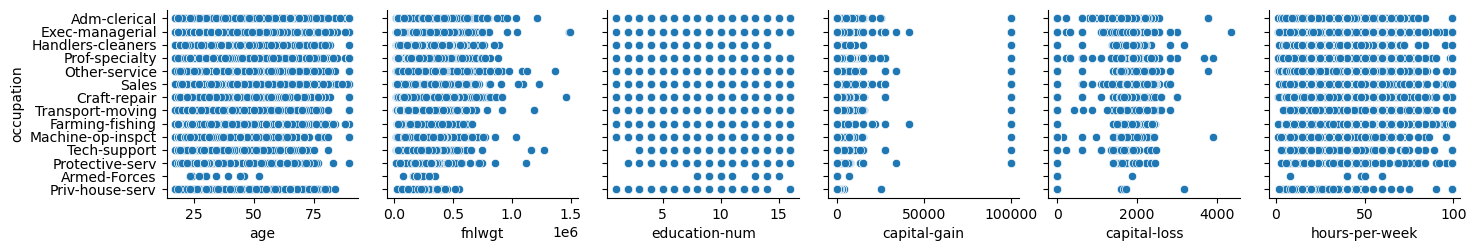

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(data=df, y_vars =['occupation'], kind = 'scatter')
plt.show()

In [10]:
non_missing = df['occupation'].dropna() 

value_counts = non_missing.value_counts(normalize=True)

df['occupation'] = df['occupation'].apply(lambda x: np.random.choice(value_counts.index, p=value_counts.values) if pd.isnull(x) else x)

print(df['occupation'].value_counts())

Prof-specialty       6558
Craft-repair         6474
Exec-managerial      6449
Adm-clerical         5961
Sales                5838
Other-service        5207
Machine-op-inspct    3228
Transport-moving     2495
Handlers-cleaners    2192
Farming-fishing      1586
Tech-support         1540
Protective-serv      1039
Priv-house-serv       257
Armed-Forces           18
Name: occupation, dtype: int64


#### Notes:

- The occupation feature proved to be split across many categories with most of them well represented.
- The feature also showed no significant relationship with other features from the pairplot.
- Simple Imputation of the most frequent category would have therefore skewed the sample, whilst there didn't appear to be any strong enough relationships that a model potentially use to predict the occupation.
- Also, the latter would have been a multivariate prediction which is likely to perform worse, and even then it would have taken up more resources which aren't necessary in this exercise.
- Therefore, a random imputation seemed the best option. It preserves the respective balance of the categories while getting rid of nulls. With the idea that by preserving the balance, the models used later will perform better.

### Data Cleaning - 'workclass'

In [11]:
print(df['workclass'].value_counts())

Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64


In [12]:
df['workclass'] = imp_null_most_frequent.fit_transform(df[['workclass']])

print(df['workclass'].value_counts())

Private             36705
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64


#### Notes:
- As roughly 75% of the 'workclass' feature stored the same category, I commited to replacing the nulls with the most frequent value, believing this method would represent the data sample the best and lead to the most accurate models.

## Feature Engineering:

### Feature Engineering - Dropping 'fnlwgt'

In [13]:
df = df.drop(columns = 'fnlwgt')

print(df.head())

   age         workclass  education  education-num      marital-status  \
0   39         State-gov  Bachelors             13       Never-married   
1   50  Self-emp-not-inc  Bachelors             13  Married-civ-spouse   
2   38           Private    HS-grad              9            Divorced   
3   53           Private       11th              7  Married-civ-spouse   
4   28           Private  Bachelors             13  Married-civ-spouse   

          occupation   relationship   race     sex  capital-gain  \
0       Adm-clerical  Not-in-family  White    Male          2174   
1    Exec-managerial        Husband  White    Male             0   
2  Handlers-cleaners  Not-in-family  White    Male             0   
3  Handlers-cleaners        Husband  Black    Male             0   
4     Prof-specialty           Wife  Black  Female             0   

   capital-loss  hours-per-week native-country income  
0             0              40  United-States  <=50K  
1             0              13  U

#### Notes:

- Dropping the feature 'fnlwgt' as it serves no purpose to model performance, it being a remnant ID feature.

### Feature Engineering - 'capital-net'

In [14]:
df['capital-net'] = df['capital-gain']-df['capital-loss']

print(df[['capital-gain', 'capital-loss', 'capital-net']].head())
print(df[['capital-gain', 'capital-loss', 'capital-net']].describe())

   capital-gain  capital-loss  capital-net
0          2174             0         2174
1             0             0            0
2             0             0            0
3             0             0            0
4             0             0            0
       capital-gain  capital-loss   capital-net
count  48842.000000  48842.000000  48842.000000
mean    1079.067626     87.502314    991.565313
std     7452.019058    403.004552   7475.549906
min        0.000000      0.000000  -4356.000000
25%        0.000000      0.000000      0.000000
50%        0.000000      0.000000      0.000000
75%        0.000000      0.000000      0.000000
max    99999.000000   4356.000000  99999.000000


#### Notes:

- Engineering another feature, made up of net capital gains and losses could add further insight at the data exploration stage and in the models accuracy once deployed.

### Data Exploration:

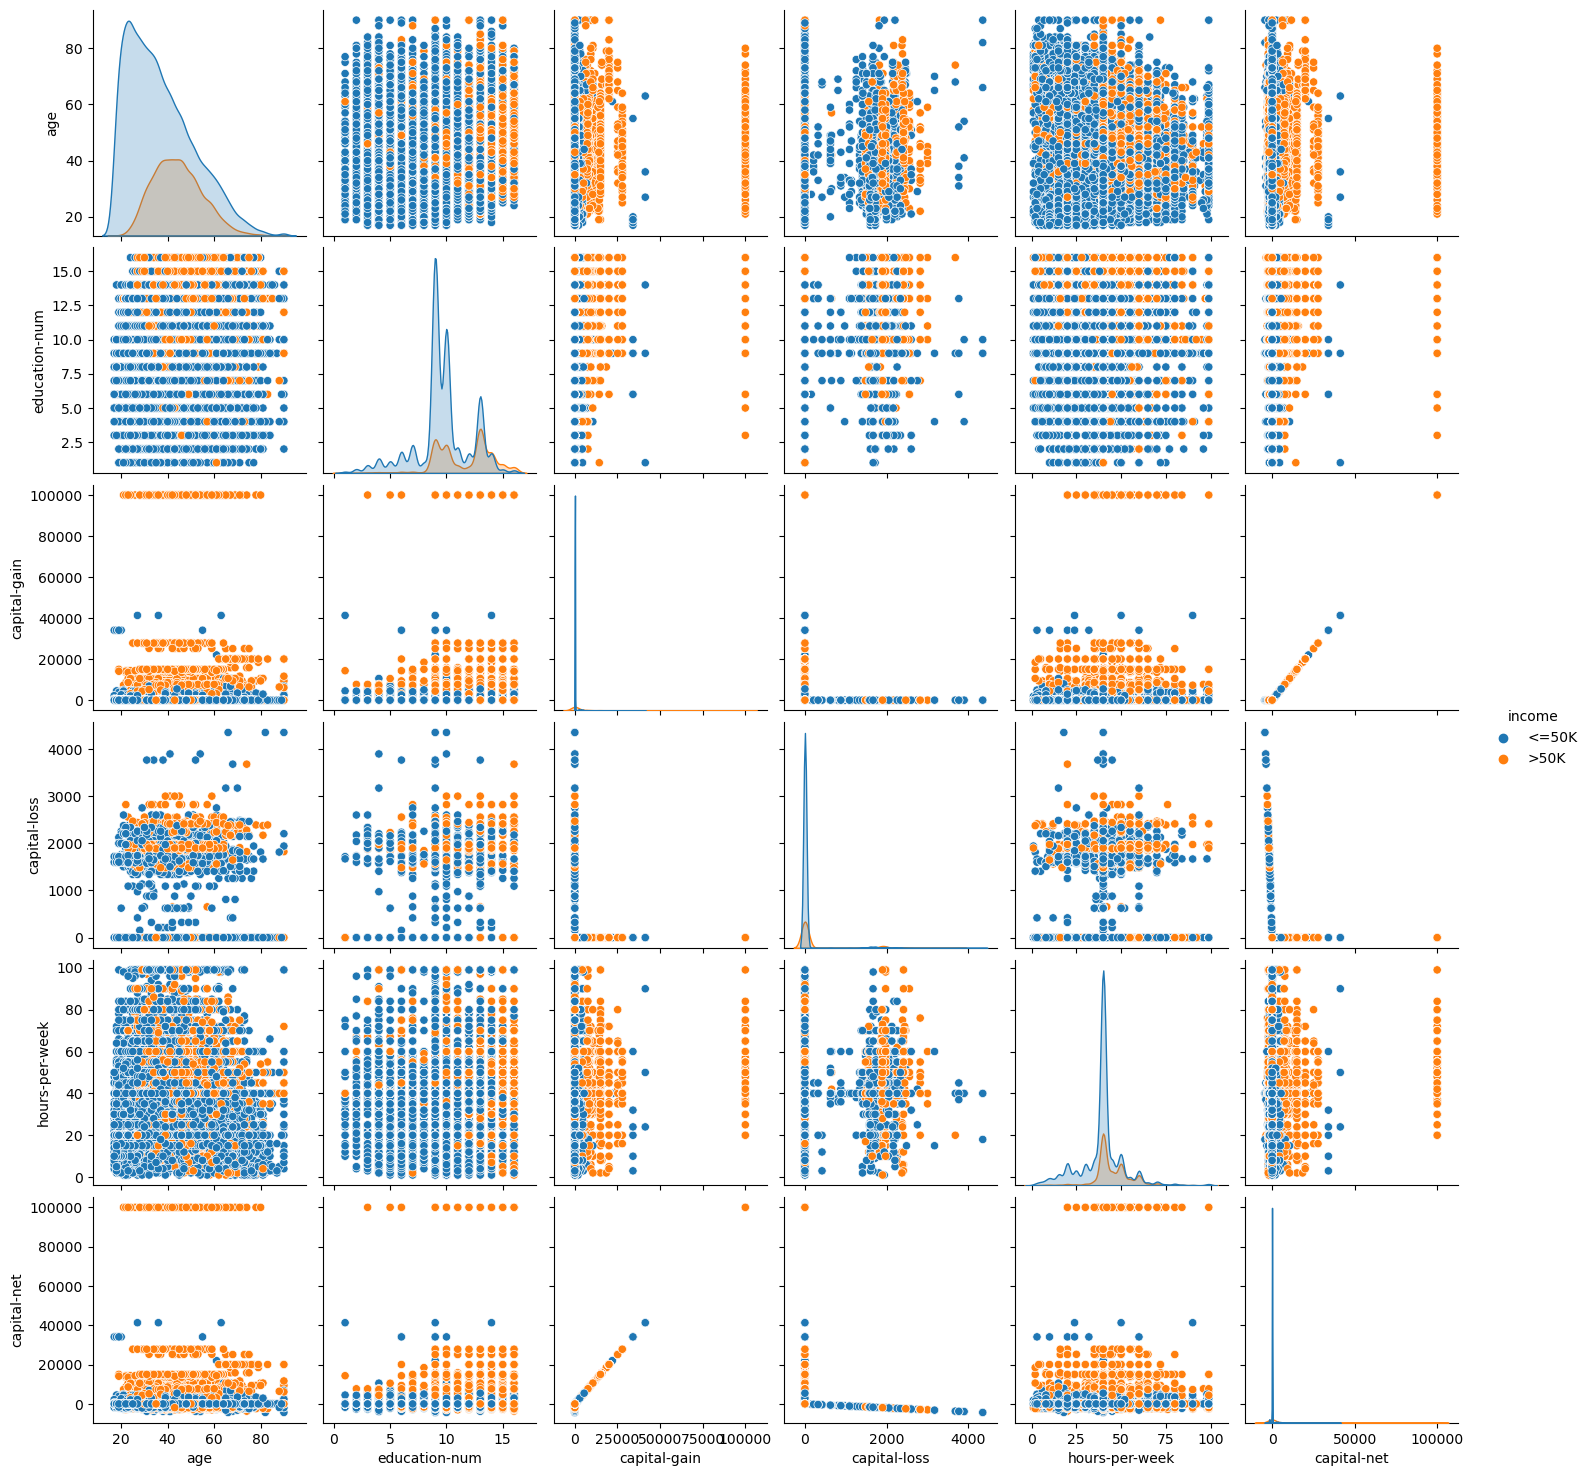

In [15]:
sns.pairplot(df, hue = 'income')
plt.show()

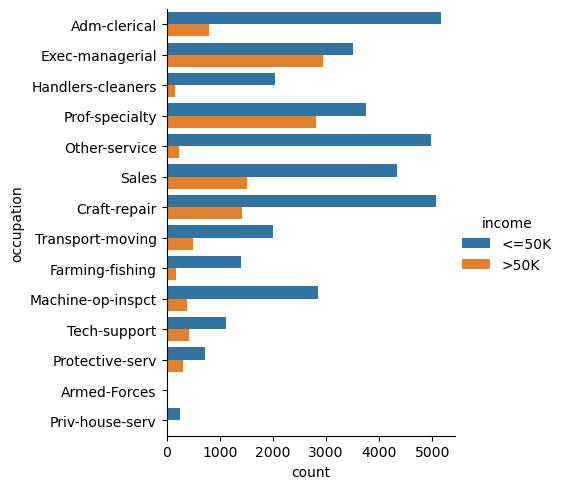

In [16]:
sns.catplot(data = df, hue= 'income', y = 'occupation', kind = 'count')
plt.show()

#### Notes:

- Incomes over 50k cluster on the higher the 'education-num', 'hours-per-week', and 'capital-net'. Indicating these will be the significant features in classing the target 'income' over >50k.
- 'Age' also tends to be a determinant of 'income', with the distribution of >50k peaking at a higher age then <=50k. Therefore, this although not as significant as the previous, would expect to be a important feature.
- 'Occupation' will also be a significant feature in the accuracy of the model, as 2 categories of this feature have considerably more incomes 50k than the other 12, both by absolute value and as a proportion of the individual category.

## Data PreProcessing

### Data PreProcessing - Splitting df into y and X to be processed.

In [17]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

X_unprocessed = df.drop(columns = 'income')
y = df['income']

X_to_OneHotEncoder = X_unprocessed.select_dtypes(include = 'object')
X_to_OrdinalEncoder = X_unprocessed['education-num']
X_to_StandarScaler = X_unprocessed.select_dtypes(include = 'number').drop(columns = 'education-num')

print(X_to_OneHotEncoder.head())
print(X_to_OrdinalEncoder.head())
print(X_to_StandarScaler.head())
print(y.head())

          workclass  education      marital-status         occupation  \
0         State-gov  Bachelors       Never-married       Adm-clerical   
1  Self-emp-not-inc  Bachelors  Married-civ-spouse    Exec-managerial   
2           Private    HS-grad            Divorced  Handlers-cleaners   
3           Private       11th  Married-civ-spouse  Handlers-cleaners   
4           Private  Bachelors  Married-civ-spouse     Prof-specialty   

    relationship   race     sex native-country  
0  Not-in-family  White    Male  United-States  
1        Husband  White    Male  United-States  
2  Not-in-family  White    Male  United-States  
3        Husband  Black    Male  United-States  
4           Wife  Black  Female           Cuba  
0    13
1    13
2     9
3     7
4    13
Name: education-num, dtype: int64
   age  capital-gain  capital-loss  hours-per-week  capital-net
0   39          2174             0              40         2174
1   50             0             0              13            0
2

#### Notes:

- The df contains standard categorical features, numerical features, and one feature of a ordinal categorical type. Therefore, they have to be treated seperately to get them processed for the models.
- This is so the data is in the most suitable format to produce accurate and usable models, as no feature will dominate and skew development incorrectly.

### Data Preprocessing - X features for OneHotEncoder

In [18]:
onehotencoder = OneHotEncoder()
X_from_OneHotEncoder = onehotencoder.fit_transform(X_to_OneHotEncoder).toarray()
X_processed_OneHotEncoder = pd.DataFrame(data = X_from_OneHotEncoder, columns = onehotencoder.get_feature_names_out())

print(X_processed_OneHotEncoder.head())

   workclass_Federal-gov  workclass_Local-gov  workclass_Never-worked  \
0                    0.0                  0.0                     0.0   
1                    0.0                  0.0                     0.0   
2                    0.0                  0.0                     0.0   
3                    0.0                  0.0                     0.0   
4                    0.0                  0.0                     0.0   

   workclass_Private  workclass_Self-emp-inc  workclass_Self-emp-not-inc  \
0                0.0                     0.0                         0.0   
1                0.0                     0.0                         1.0   
2                1.0                     0.0                         0.0   
3                1.0                     0.0                         0.0   
4                1.0                     0.0                         0.0   

   workclass_State-gov  workclass_Without-pay  education_10th  education_11th  \
0                  1.0 

#### Notes:

- OneHotEncoder returns a 1d array when a dataframe requires a 2d array, therefore the toarray() method is used so that it can be reconverted into a DataFrame.

### Data Preprocessing - X feature for OrdinalEncoder

In [19]:
ordinalencoder = OrdinalEncoder()
X_to_OrdinalEncoder_reshaped = X_to_OrdinalEncoder.values.reshape(-1, 1) ## Series to 2d array
X_from_OrdinalEncoder = ordinalencoder.fit_transform(X_to_OrdinalEncoder_reshaped)
X_processed_OrdinalEncoder = pd.DataFrame(data = X_from_OrdinalEncoder, columns = ['educational-num'])

print(X_processed_OrdinalEncoder.describe())

       educational-num
count     48842.000000
mean          9.078089
std           2.570973
min           0.000000
25%           8.000000
50%           9.000000
75%          11.000000
max          15.000000


#### Notes:

- Due to the only OrdinalFeature being a series, it is necessary to reshape the values so that it is a 2d array. Permetting the ordinalencoder to function.

### Data Preprocessing - X features for StandardScaler

In [20]:
scaler = StandardScaler()
X_from_StandardScaler = scaler.fit_transform(X_to_StandarScaler)
X_processed_StandardScaler = pd.DataFrame(data = X_from_StandardScaler, columns = scaler.get_feature_names_out())

print(X_processed_StandardScaler.head())

        age  capital-gain  capital-loss  hours-per-week  capital-net
0  0.025996      0.146932     -0.217127       -0.034087     0.158175
1  0.828308     -0.144804     -0.217127       -2.213032    -0.132642
2 -0.046942     -0.144804     -0.217127       -0.034087    -0.132642
3  1.047121     -0.144804     -0.217127       -0.034087    -0.132642
4 -0.776316     -0.144804     -0.217127       -0.034087    -0.132642


### Data Preprocessing - Remerging X features

In [21]:
X = pd.concat([X_processed_OneHotEncoder, X_processed_OrdinalEncoder, X_processed_StandardScaler], axis = 1)

print(X.head())

   workclass_Federal-gov  workclass_Local-gov  workclass_Never-worked  \
0                    0.0                  0.0                     0.0   
1                    0.0                  0.0                     0.0   
2                    0.0                  0.0                     0.0   
3                    0.0                  0.0                     0.0   
4                    0.0                  0.0                     0.0   

   workclass_Private  workclass_Self-emp-inc  workclass_Self-emp-not-inc  \
0                0.0                     0.0                         0.0   
1                0.0                     0.0                         1.0   
2                1.0                     0.0                         0.0   
3                1.0                     0.0                         0.0   
4                1.0                     0.0                         0.0   

   workclass_State-gov  workclass_Without-pay  education_10th  education_11th  \
0                  1.0 

#### Notes: 

- Concatenating the processed features into 1 dataframe again 'X', so that it's ready to be split into test and train sets.

### Data Preprocessing - Y for Label Encoder

In [22]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
y_encoded = labelencoder.fit_transform(y)

print(y_encoded[0:10])

[0 0 0 0 0 0 0 1 1 1]


#### Notes:

- It's necessary to encode the target variable y ('income') so that it's ready for model development, as it is currently in text rather than numeric format.

### Data Preprocessing - Train_Test_Split

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded,
                                                    test_size = 0.25, 
                                                    random_state = 42, 
                                                    stratify = y)

print(f'Training sample size: {X_train.shape}')
print(f'Test sample size: {X_test.shape}')

Training sample size: (36631, 105)
Test sample size: (12211, 105)


#### Notes:

- Stratifying the train_test_split so that the proportion of the classes is the same in both the train and test sets. Ensuring that it reduces sampling error and leads to more accurate models.
- Likewise random_state is set to ensure reproducability.

## Model Development

### SVC Model:

In [24]:
from sklearn.svm import LinearSVC

svc = LinearSVC(dual = False, class_weight = 'balanced', random_state = 42, max_iter = 1000)

svc.fit(X_train, y_train)

svc_accuracy = svc.score(X_test, y_test)

print(f'SVC Accuracy: {svc_accuracy:.4f}')

SVC Accuracy: 0.7989


#### Notes:

- As the the classes are not equal I have balanced them for the model, with the goal of the model performing equally as well on each class.
- Dual has also been set to false as the samples are greater in number than the features.
- On the surface, an accuracy of 0.798 is a good benchmark score. However in consideration that the sample has roughly 77% of one class over the other, this is less impressive. By simply predicting all as the most frequent class we would only fall 2-3% behind on accuracy vs the model.

### SVC Confusion Matrix:

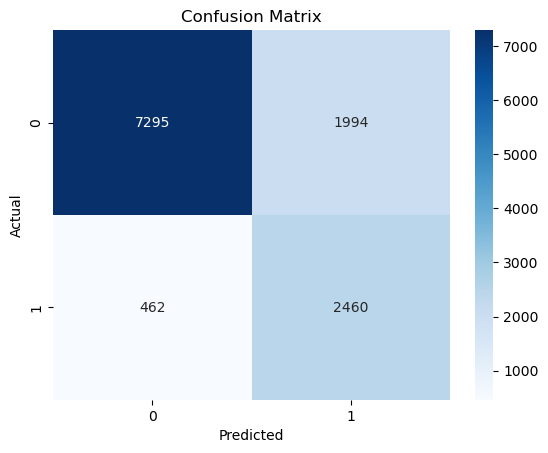

In [25]:
from sklearn.metrics import confusion_matrix

svc_y_pred = svc.predict(X_test)

svc_confusion_matrix = confusion_matrix(y_test, svc_y_pred)

sns.heatmap(svc_confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Notes:

- Balancing the weight has shown to be useful as both classes are being predicted proportionately correct.
- Class 0 = 7295 correct, Class 1 = 1994 incorrect.
- Class 1 = 2460 correct, 462 incorrect.

### Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=2, 
                             class_weight='balanced', random_state=42)

rfc.fit(X_train, y_train)

rfc_accuracy = rfc.score(X_test, y_test)

print(f'RFC Accuracy: {rfc_accuracy:.4f}')

RFC Accuracy: 0.8236


#### Notes:

- Once again class weights are balanced and random_state set.
- The RFC accuracy is 0.8236, an improvement on the SVC model by 2% and distancing itself a little in terms of accuracy in contrast to the most frequent class.

### RFC Confusion Matrix

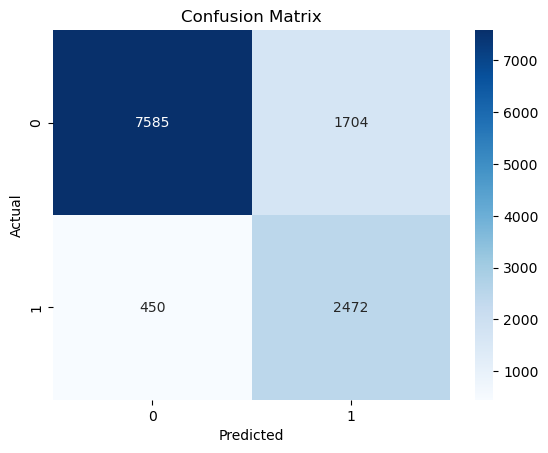

In [27]:
rfc_y_pred = rfc.predict(X_test)

rfc_confusion_matrix = confusion_matrix(y_test, rfc_y_pred)

sns.heatmap(data = rfc_confusion_matrix, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


#### Notes:

- Once again, the model performs on both classes.
- Class 0 = 7585 correct, Class 1 = 1704 incorrect.
- Class 1 = 2472 correct, 450 incorrect.
- The Random Forest model shows to find increased performance over the SVC model in class 0, predicting more than 250 cases correct in comparison.

## Model Tuning

### SVC Tuning

In [28]:
from sklearn.model_selection import GridSearchCV

svc_params = {'C': [0.1, 1, 10, 100, 1000]}

svc_grid = GridSearchCV(LinearSVC(max_iter = 1000, random_state = 42, dual=False, class_weight = 'balanced')
                        , svc_params
                        , cv = 5)

svc_grid.fit(X, y_encoded)

print(f'Best accuracy for SVC grid search: {svc_grid.best_score_}')
print(f'Best parameters for SVC grid search: {svc_grid.best_params_}')

Best accuracy for SVC grid search: 0.8025880727692583
Best parameters for SVC grid search: {'C': 0.1}


#### Notes:

- Linear SVC model performed better, however by an insignificant margin. Also, it's still behind the accuracy of the untuned Random Forest.

### Random Forest Model Tuning

In [30]:
rfc_params = {
    'n_estimators': [200, 300, 400],               
    'max_depth': [10, 20, 30], 
    'min_samples_leaf': [2],            
    'min_samples_split': [5],            
    'class_weight': ['balanced'],
    'random_state': [42]                 
}

rfc_grid = GridSearchCV(RandomForestClassifier(), rfc_params, cv=5)

rfc_grid.fit(X, y_encoded)

print(f'Best Accuracy for Random Forest grid search: {rfc_grid.best_score_}')
print(f'Best Parameters for Random Forest grid search: {rfc_grid.best_params_}')


Best Accuracy for Random Forest grid search: 0.8333197098679748
Best Parameters for Random Forest grid search: {'class_weight': 'balanced', 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 42}


#### Notes:

- Likewise, the Random Forest performed better by a percantage. Not enough to warrant a significant change. Yet it remains the stronger model.

## Model Evaluation

### Tuned SVC Classification Report

In [34]:
from sklearn.metrics import classification_report

svc_tuned = LinearSVC(C = 0.1, max_iter = 1000, random_state = 42, dual=False, class_weight = 'balanced')

svc_tuned.fit(X_train, y_train)

svc_tuned_ypred = svc_tuned.predict(X_test)

print(classification_report(y_test, svc_tuned_ypred))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86      9289
           1       0.55      0.84      0.67      2922

    accuracy                           0.80     12211
   macro avg       0.75      0.81      0.76     12211
weighted avg       0.85      0.80      0.81     12211



### SVC Feature Importance

In [49]:
feature_names = X_train.columns

svc_feature_importance = pd.DataFrame(data = svc_tuned.coef_,
            columns = feature_names)

svc_feature_importance = svc_feature_importance.T


svc_feature_importance.columns = ['Coef']

svc_feature_importance['ABS Coef'] = svc_feature_importance['Coef'].abs()

svc_feature_importance.sort_values(by=['ABS Coef'], ascending = False, inplace = True)

print(svc_feature_importance.head(10))

                                      Coef  ABS Coef
native-country_Laos              -0.609452  0.609452
occupation_Priv-house-serv       -0.554404  0.554404
native-country_Columbia          -0.506871  0.506871
sex_Female                       -0.460450  0.460450
marital-status_Married-AF-spouse  0.436105  0.436105
education_Preschool              -0.430519  0.430519
marital-status_Never-married     -0.395846  0.395846
occupation_Farming-fishing       -0.393087  0.393087
native-country_South             -0.391819  0.391819
capital-gain                      0.377952  0.377952


### Tuned Random Forest Classification Report

In [38]:
from sklearn.metrics import classification_report

rfc_tuned = RandomForestClassifier(n_estimators = 200, 
                                    max_depth = 30,
                                    min_samples_leaf = 3,
                                    min_samples_split = 5,
                                    random_state = 42,
                                    class_weight = 'balanced')

rfc_tuned.fit(X_train, y_train)

rfc_tuned_ypred = svc_tuned.predict(X_test)

print(classification_report(y_test, rfc_tuned_ypred))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86      9289
           1       0.55      0.84      0.67      2922

    accuracy                           0.80     12211
   macro avg       0.75      0.81      0.76     12211
weighted avg       0.85      0.80      0.81     12211



### Random Forest Feature Importance

In [52]:
rfc_feature_importance = pd.DataFrame(data=rfc_tuned.feature_importances_,
                                       index=feature_names, 
                                       columns=['Importance'])


rfc_feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

print(rfc_feature_importance.head(10))

                                   Importance
marital-status_Married-civ-spouse    0.144624
age                                  0.100254
educational-num                      0.097411
relationship_Husband                 0.085575
capital-net                          0.070578
capital-gain                         0.063358
marital-status_Never-married         0.058716
hours-per-week                       0.051665
relationship_Own-child               0.028087
relationship_Wife                    0.021813


#### Notes:

- Both LinearSVC and Random Forest Model performed equally as well on the classification report, with the weight F1 score for each being 0.81. This is despite the Random Forest model scoring a higher accuracy previously.
- The features which had the most impact however differed, only 'capital-gain' and 'marital-status' showed up in each as having a high importance.
- However, this is likely because of the different methods being employed, where Random Forest uses Tree's/Nodes it will often split by the most used features.
- Whereas Linear SVC will indicate that for example, being from Laos is a key feature, but the amount of instances that are are positive in this feature, are negligible in contrast to the size of the total sample.
- Linear SVC would indicate that occupation, native country and sex are important also.
- Random Forest would indicate education, and hours per week are important.


## Conclusions

#### Neither model performed exceptionally in contrast to what we would have if we used a dummy 'most_frequent' classifier. The Random Forest overall was stronger but not by a significant margin to warrant deployment. In this instance, I would go back and try collecing more data and doing more feature engineering to try and build a successful model.